In [6]:
#Importing the necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [8]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100
original_reviews = []
cleaned_reviews = []

In [10]:
#Scrapping the reviews
for i in range(1, pages + 1):
    print(f"Scraping page {i}...")

    # Generate the URL for the current page
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Request the content of the page
    response = requests.get(url)
    response.raise_for_status()  # Check for HTTP request errors

    # Parse the page content
    parsed_content = BeautifulSoup(response.content, 'html.parser')

    # Extract and process reviews
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        original_review = para.get_text().strip()  # Strip leading/trailing spaces
        cleaned_review = original_review.split('|', 1)[-1].strip()  # Cleaned part after '|'
        
        # Standardize the cleaned review text
        cleaned_review = cleaned_review.lower()

        # Append both original and cleaned reviews
        original_reviews.append(original_review)
        cleaned_reviews.append(cleaned_review)

    print(f"   ---> {len(cleaned_reviews)} total cleaned reviews so far")

# Created a DataFrame with both original and cleaned reviews as separate columns
df = pd.DataFrame({
    "original_review": original_reviews,
    "cleaned_review": cleaned_reviews
})

# Remove duplicates from cleaned reviews
df.drop_duplicates(subset=["cleaned_review"], inplace=True)  

# Final review count after cleaning
print(f"Scraping and cleaning completed. Total cleaned reviews: {len(df)}")

# Display the first 5 rows with both original and cleaned reviews
df.head()

Scraping page 1...
   ---> 100 total cleaned reviews so far
Scraping page 2...
   ---> 200 total cleaned reviews so far
Scraping page 3...
   ---> 300 total cleaned reviews so far
Scraping page 4...
   ---> 400 total cleaned reviews so far
Scraping page 5...
   ---> 500 total cleaned reviews so far
Scraping page 6...
   ---> 600 total cleaned reviews so far
Scraping page 7...
   ---> 700 total cleaned reviews so far
Scraping page 8...
   ---> 800 total cleaned reviews so far
Scraping page 9...
   ---> 900 total cleaned reviews so far
Scraping page 10...
   ---> 1000 total cleaned reviews so far
Scraping and cleaning completed. Total cleaned reviews: 1000


,original_review,cleaned_review
0,Not Verified | Happy with the flight crew. Ha...,happy with the flight crew. hadn't been on a p...
1,✅ Trip Verified | Horrible service from boar...,horrible service from boarding to landing. i f...
2,Not Verified | My wife and I are very disappo...,my wife and i are very disappointed with flyin...
3,Not Verified | We flew BA between Heathrow an...,we flew ba between heathrow and berlin one way...
4,Not Verified | Absolutely disgusted with BA. ...,absolutely disgusted with ba. our flights were...


In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Assuming your DataFrame 'df' has a column 'cleaned_review' with the cleaned text
def clean_text(text):
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    words = text.split()
    
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the words back into one string
    return ' '.join(words)

# Apply the cleaning function to the 'cleaned_review' column
df['cleaned_review'] = df['cleaned_review'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vishakkrishnan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vishakkrishnan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
df.head()

,original_review,cleaned_review
0,Not Verified | Happy with the flight crew. Ha...,happy flight crew hadnt plane year stressed ma...
1,✅ Trip Verified | Horrible service from boar...,horrible service boarding landing flew london ...
2,Not Verified | My wife and I are very disappo...,wife disappointed flying british airway flight...
3,Not Verified | We flew BA between Heathrow an...,flew ba heathrow berlin one way connection exp...
4,Not Verified | Absolutely disgusted with BA. ...,absolutely disgusted ba flight cancelled may b...


In [16]:
# Convert the cleaned text into a matrix of token counts
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_review'])

# Apply Latent Dirichlet Allocation to discover topics
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(dtm)

# Display the topics with the top 10 words
for index, topic in enumerate(LDA.components_):
    print(f'Topic #{index + 1}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print('\n')

Topic #1:
['drink', 'cabin', 'time', 'service', 'crew', 'food', 'seat', 'good', 'ba', 'flight']


Topic #2:
['airline', 'cancelled', 'service', 'day', 'airway', 'british', 'customer', 'hour', 'ba', 'flight']


Topic #3:
['british', 'london', 'staff', 'airline', 'service', 'flight', 'ba', 'business', 'class', 'seat']


Topic #4:
['plane', 'late', 'staff', 'minute', 'boarding', 'time', 'gate', 'hour', 'ba', 'flight']


Topic #5:
['chicken', 'great', 'passenger', 'meal', 'staff', 'ba', 'cabin', 'service', 'flight', 'crew']




In [18]:
# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis
df['sentiment'] = df['cleaned_review'].apply(get_sentiment)

# Categorize sentiment into positive, negative, and neutral
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Display sentiment distribution
print(df['sentiment_category'].value_counts())
df.head()

sentiment_category
positive    619
negative    364
neutral      17
Name: count, dtype: int64


,original_review,cleaned_review,sentiment,sentiment_category
0,Not Verified | Happy with the flight crew. Ha...,happy flight crew hadnt plane year stressed ma...,0.300000,positive
1,✅ Trip Verified | Horrible service from boar...,horrible service boarding landing flew london ...,-0.583333,negative
2,Not Verified | My wife and I are very disappo...,wife disappointed flying british airway flight...,-0.262500,negative
3,Not Verified | We flew BA between Heathrow an...,flew ba heathrow berlin one way connection exp...,0.176705,positive
4,Not Verified | Absolutely disgusted with BA. ...,absolutely disgusted ba flight cancelled may b...,-0.381250,negative


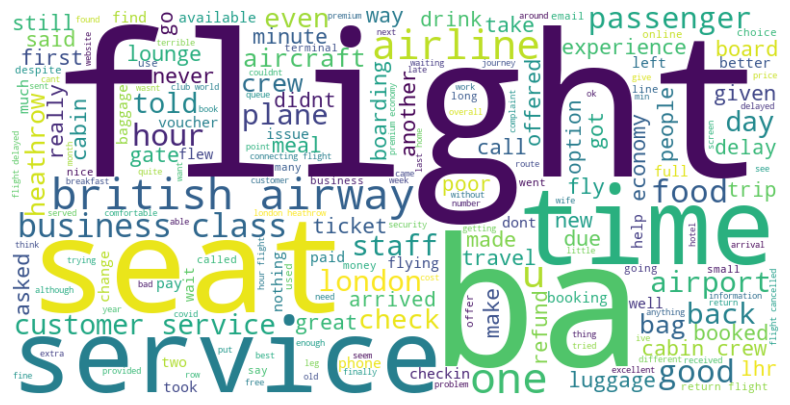

In [20]:
# Combine all the reviews into one string
all_reviews = ' '.join(df['cleaned_review'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

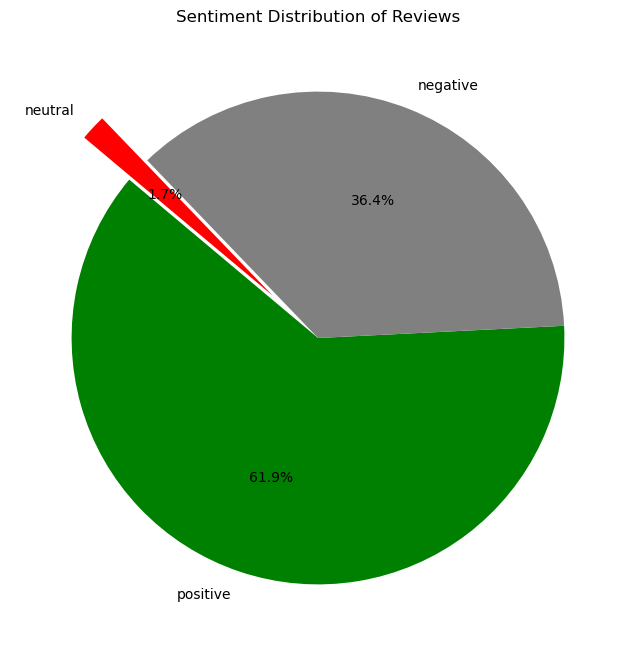

In [22]:
# Count the number of reviews in each sentiment category
sentiment_counts = df['sentiment_category'].value_counts()

# Define labels, sizes, and colors for the pie chart
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['green', 'gray', 'red']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, explode = (0, 0, 0.25),autopct='%1.1f%%', startangle=140, shadow=False)
plt.title('Sentiment Distribution of Reviews')
plt.show()

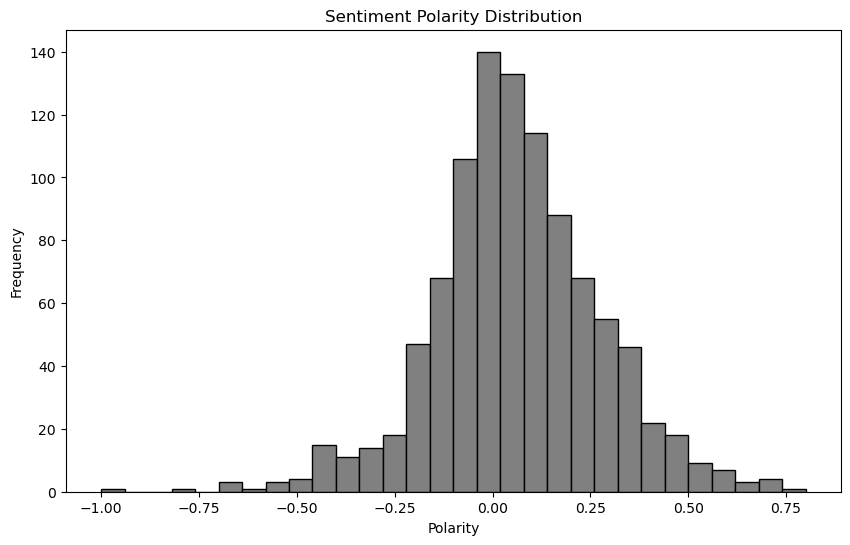

In [24]:
# Plot the sentiment polarity distribution
plt.figure(figsize=(10, 6))
plt.hist(df['sentiment'], bins=30, color='gray', edgecolor='black')
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

In [32]:
# Save the DataFrame to a CSV file
output_file_path = '/Users/vishakkrishnan/Documents/data/cleaned_reviews.csv' 
df.to_csv(output_file_path, index=False)